# WORKFLOW for the creation of the ML potentials at Constant Potential

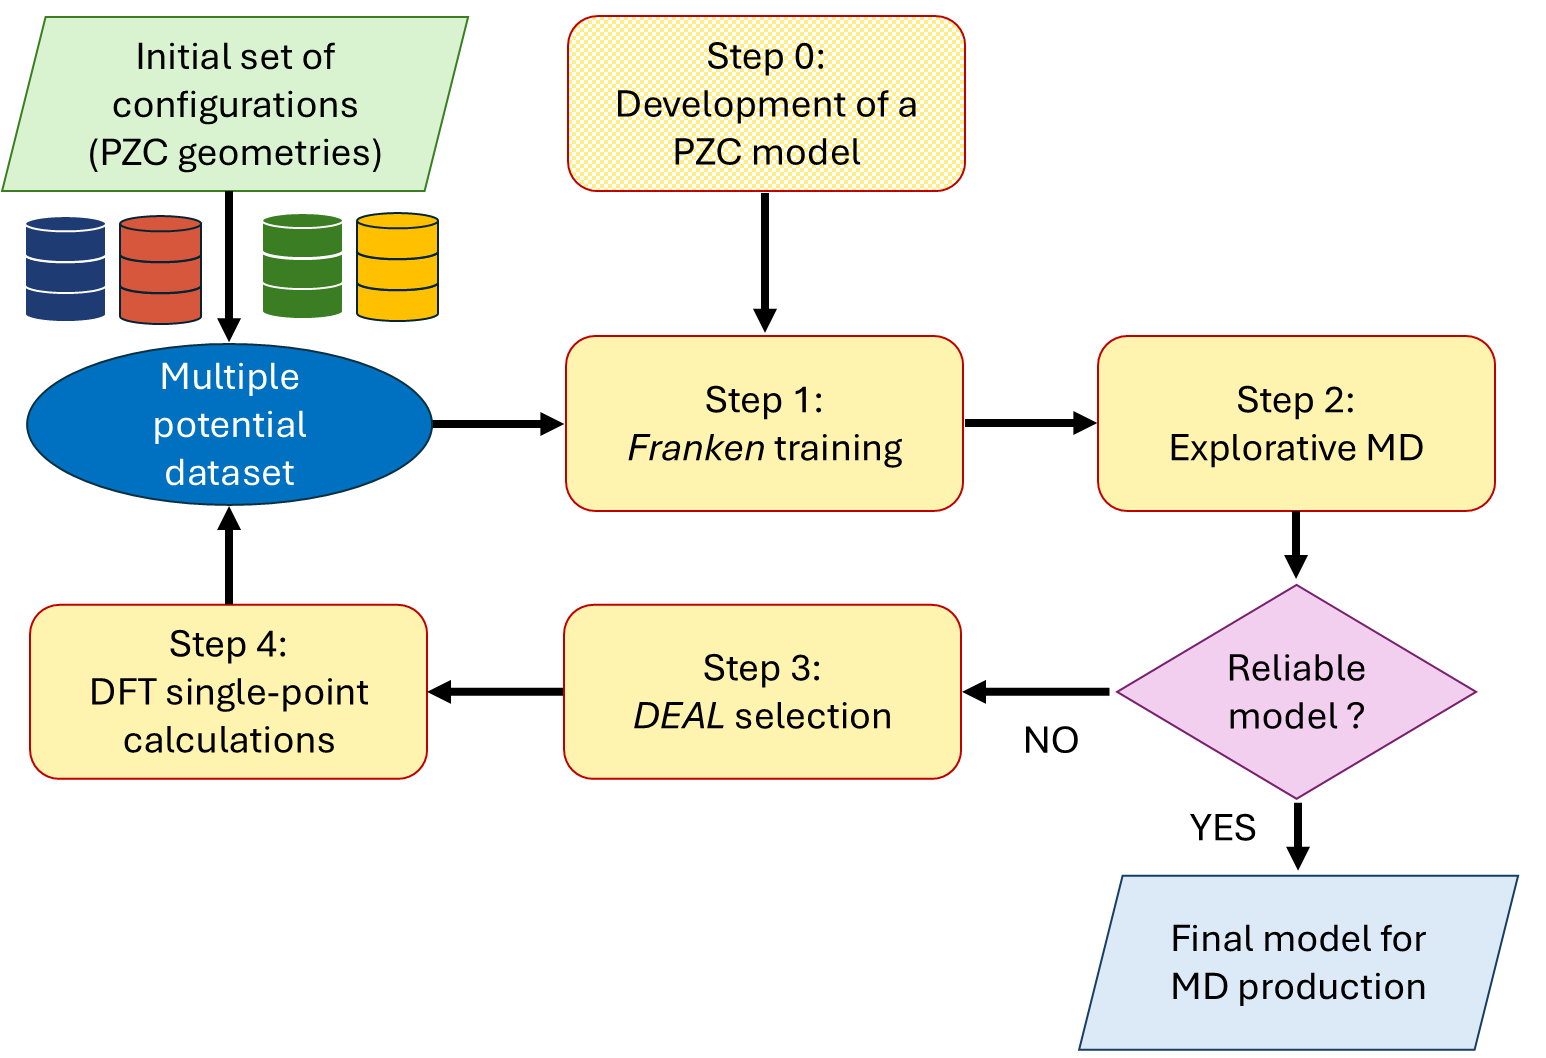

In [1]:
from IPython.display import Image
Image(filename='CP_workflow_general.png')

In [1]:
# Imports:
import numpy as np
import sys
import os
import glob
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
from datetime import datetime


from ase import Atom
from ase.io import read,write

#Path to the WORKFLOW_utils directory
# MODIFY IF NEEDED
workflow_utils_path = "../"
sys.path.append(workflow_utils_path)

In [2]:
# SPECIFY the values of target potentials to be used in the calculations
V_vector = [-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0]
V_vector = np.array(V_vector)

print("Target potentials (V vs SHE) to be used in the calculations:\n",V_vector)

from workflow_utils.python_utils import convert_V_to_label

V_vector_labels=convert_V_to_label(V_vector)

print("Corresponding labels for the target potentials:\n",V_vector_labels)

Target potentials (V vs SHE) to be used in the calculations:
 [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
Corresponding labels for the target potentials:
 ['m05', 'm075', 'm1', 'm125', 'm15', 'm175', 'm2']


# STEP 1: Training via Transfer Learning

In [3]:
os.chdir('Training')

os.chdir('Dataset')
# Create the folders for the different target potentials, if not already present
for V in V_vector_labels:
    if not os.path.exists(f"{V}"):
        os.mkdir(f"{V}")
os.chdir('..')

print(os.listdir())

# This directory includes:
# 1) The dataset (in "Dataset") => Here, there are the ext-xyz files with the energies, forces, Bader charges etc..
#                                  computed at the DFT level for each atomic configuration.
#                                  The dataset is split in folders according to the target potential (e.g., "m05", "m075", "m1" etc...)
#                                  - IF this is the first cycle of active learning, the initial dataset can be composed 
#                                    by configurations of the PZC dataset and labelled at constant potential
#                                    subsequent DFT labelling.
#                                  - IF this is NOT the first cycle of active learning, the dataset is the one of the
#                                    previous cycle + the newly labelled configurations.  
#                                !!! PZC_label folder includes the geometries compatible with the presence of extra surface charge, but labelled at the PZC level 

# 2) sbatch_Franken_multiple_pot_train_template => script to submit the training of the ML potential
#                                         at multiple potentials with Franken

# 3) run_train_Franken_API_template.py => script to train the ML potential at a specific potential via the Franken API
# 4) Folder with results of the training of the ML potential at different potentials (V) and number of Random Features (RF). 
#                               Formats of the folders: results_multi_potential/case_{V}_RF_{n_features}
                                 
os.chdir('..')

['Dataset', 'sbatch_Franken_multiple_pot_train_template', 'run_train_Franken_API_template.py']


In [3]:
# Create the scripts for the training of the ML potential at multiple potentials with Franken

from workflow_utils.python_utils import create_Franken_train_scripts

help(create_Franken_train_scripts)

#Number of Random Features to be used for the training of the ML potential
RF_cases =[1024,2048,4096,8192]

#Path to the backbone model to be used for the training of the ML potential
backbone_path = "MACE-L0"  # Path to general-purpose backbone (MACE-MP-0)
# backbone_path = "../../PZC/Training/MLFF1/MACE_Cu_H2O_PZC_1_stagetwo.model"  # Path to domain-specific backbone trained at PZC
                                                                               # Do not use the version of the MACE model already compiled 
                                                                               # (i.e. MACE_Cu_H2O_PZC_1_stagetwo_compiled.model)

Help on function create_Franken_train_scripts in module workflow_utils.python_utils:

create_Franken_train_scripts(
    V_cases,
    N_RF,
    backbone_path,
    template_sbatch_script,
    template_python_API
)
    This script creates the sbatch script for the training via Franken transfer learning
    Its also create the python script to run the training via the Franken API

    Inputs:
    - V_cases: list of target potentials to be trained, e.g. V_cases=[m05,m075,m1]
    - N_RF: vector of Random Features to be used for the training
    - backbone_path: path to the backbone model to be used for the transfer learning (default: MACE-L0)
    - template_sbatch_script: name of the template sbatch script (default: sbatch_Franken_multiple_pot_train_template)
    - template_python_API: name of the template python script for the training via the Franken API (default: run_train_Franken_API_template.py)



In [4]:
os.chdir('Training')

# Before Customize the training scripts (run_train_Franken_API_template.py)
create_Franken_train_scripts(V_cases=V_vector, N_RF=RF_cases, backbone_path=backbone_path, template_sbatch_script="sbatch_Franken_multiple_pot_train_template", template_python_API="run_train_Franken_API_template.py")

os.chdir('..')

Creating the scripts for the training of the ML potentials:

Done


In [5]:
# Create the ext-xyz files for the training of the ML potential at multiple potentials with Franken
from workflow_utils.python_utils import prepare_multiple_potential_dataset

help(prepare_multiple_potential_dataset)

Help on function prepare_multiple_potential_dataset in module workflow_utils.python_utils:

prepare_multiple_potential_dataset(V_vector, fraction_val)
    This script creates the ext-xyz files for the training and validation set of Franken multiple potential
    The files are are created in the "Training" folder

    Inputs:
    - V_vector: list of target potentials to be trained, e.g. [-0.5,-0.75,-1.0]
    - fraction_val: float, fraction of the dataset used for validation (default: 0.15)



In [6]:
os.chdir('Training/Dataset')
prepare_multiple_potential_dataset(V_vector=V_vector,fraction_val=0.15)
os.chdir('../..')

Creating xyz files for V = -0.5 V

Train_m05_union_with_head.xyz Configurations:  209
Valid_m05_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -0.75 V

Train_m075_union_with_head.xyz Configurations:  209
Valid_m075_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -1.0 V

Train_m1_union_with_head.xyz Configurations:  209
Valid_m1_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -1.25 V

Train_m125_union_with_head.xyz Configurations:  209
Valid_m125_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -1.5 V

Train_m15_union_with_head.xyz Configurations:  208
Valid_m15_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -1.75 V

Train_m175_union_with_head.xyz Configurations:  206
Valid_m175_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -2.0 V

Train_m2_union_with_head.xyz Configurations:  201
Valid_m2_union_with_head.xyz Configurations:  35 




In [7]:
# Start the training of the ML potential at multiple potentials with Franken
# Do NOT run locally, but submit the jobs to a cluster (Multi-GPU training is recommended)

os.chdir('Training')
os.system("sbatch sbatch_Franken_multiple_pot_train")
os.chdir('..')

Submitted batch job 21064166


<>:55: SyntaxWarning: invalid escape sequence '\A'
<>:55: SyntaxWarning: invalid escape sequence '\A'
/scratch_local/ipykernel_216035/1428090122.py:55: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Force RMSE [eV/$\AA$]',fontsize=13)


Results for target potential -0.5 V vs SHE:
	1024 Random Features - Best hyperparameters: 
		Length-scale: 8.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	2048 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	4096 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500


	8192 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
Results for target potential -0.75 V vs SHE:
	1024 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	2048 Random Features - Best hyperparameters: 
		Length-scale: 8.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	4096 Random Features - Best hyperparameters: 
		Length-scale: 8.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	8192 Random Features - Best hyperparameters: 
		Length-scale: 8.0, L2 penalty: 1.00e-10, Force-weight: 0.500
Results for target potential -1.0 V vs SHE:
	1024 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	2048 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	4096 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	8192 Random Features - Best hy

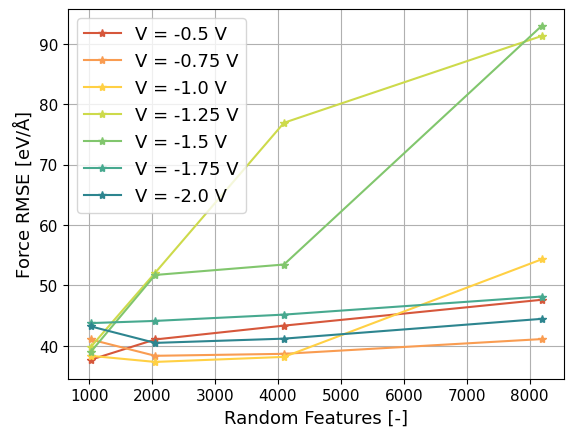

In [4]:
# Hyper-parameter analysis of the results of the training of the ML potential at multiple potentials with Franken
# In this tutorial a minimal hyper-parameter optimization has been performed for sake of simplicity=> Suggested to perform a more detailed optimization

# Choose a color palette (e.g., 'fessa_r' has 7 distinct colors)
from fessa_color_palette import fessa
# Get the colormap
cmap = plt.get_cmap('fessa_r')

# Sample colors from the colormap
palette = [cmap(i / len(V_vector_labels)) for i in range(len(V_vector_labels))]

for V,V_numerical_format,color in zip(V_vector_labels,V_vector,palette):
    print(f"Results for target potential {V_numerical_format} V vs SHE:")

    RMSE_force=[]
    for rf in RF_cases:
            
        run_dirs=glob.glob(f"Training/results_multi_potential/case_{V}_RF_{rf}/run_*/")            
            
        # Select the most recent run directory based on DAY_HOUR
        run_dirs_sorted = sorted(run_dirs, key=lambda x: datetime.strptime("20"+"_".join(x.split("_")[-3:-1]), "%Y%m%d_%H%M%S"))
        latest_run_dir = run_dirs_sorted[-1]  # Latest run

        # Path to log.json in the latest run
        log_path = os.path.join(latest_run_dir, "log.json")
        best_path= os.path.join(latest_run_dir, "best.json")
        # We load the full logs for all training runs and the logs for just the best model.
        with open(log_path, "r") as fh:
            all_logs = json.load(fh)
        with open(best_path, "r") as fh:
            best_log = json.load(fh)

        best_lenght_scale = best_log["hyperparameters"]["random_features"]["length_scale"]
        best_l2 = best_log["hyperparameters"]["solver"]["l2_penalty"]
        best_fw = best_log["hyperparameters"]["solver"]["force_weight"]
        print(f"\t{rf} Random Features - Best hyperparameters: ")
        print(f"\t\tLength-scale: {best_lenght_scale:.1f}, L2 penalty: {best_l2:.2e}, Force-weight: {best_fw:.3f}")

        # Extract metrics (e.g., RMSE on forces)

        logs_df = pd.json_normalize(all_logs)  # flattens nested dictionaries and converts to DataFrame
        logs_df.head()
        df_fw = logs_df[  # Fix the other hyperparameters
                (logs_df["hyperparameters.solver.l2_penalty"] == best_l2) & (logs_df["hyperparameters.solver.force_weight"] == best_fw) & (logs_df["hyperparameters.random_features.length_scale"]==best_lenght_scale) 
            ]
        RMSE_force.append(df_fw["metrics.validation.forces_RMSE"].values[0])

    plt.plot(RF_cases,RMSE_force, label=f"V = {V_numerical_format} V",color=color,marker='*')

# Plot accuracy vs RMSE at different applied potential

params = {'mathtext.default': 'regular' } 
plt.rcParams.update(params)
plt.xlabel('Random Features [-]',fontsize=13)
plt.ylabel('Force RMSE [eV/$\AA$]',fontsize=13)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.grid()
plt.legend(fontsize=13)
plt.show()

In [8]:
# Choose the random features values used for the different potential cases
print('The target potentials (V vs SHE) are: ', V_vector)

# The dataset size is very small so the most safe choice is a small number of Random Features
rf_chosen = [1024]*len(V_vector)  # Example choice of RF for each potential
if len(rf_chosen) != len(V_vector):
    raise ValueError("Length of rf_chosen must be equal to the length of V_vector") 
print('The corresponding random features are: ',rf_chosen)

The target potentials (V vs SHE) are:  [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
The corresponding random features are:  [1024, 1024, 1024, 1024, 1024, 1024, 1024]
